# **PUC Minas - Pontifícia Universidade Católica de Minas Gerais**

# **Pós Graduação em Ciência de Dados e Big Data**


#**Trabalho de conclusão de curso**


**Título:** MÉTODOS DE PREDIÇÃO APLICADOS A DEPENDENTES QUÍMICOS EM SITUAÇÃO DE RUA NA CIDADE DO RIO DE JANEIRO


**Aluno:** Sidney de Oliveira Wergles


**Matrícula**: 1155116

# Importação de Bibliotecas

In [ ]:
!pip install unidecode --quiet
!pip install bs4 --quiet
!pip install sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import requests 
import unicodedata
import plotly.express as px
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from unidecode import unidecode
from scipy import stats
from google.colab import output
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from google.colab import data_table
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=1f7e3b9e90a6ae30cd2595d4a21ea9ce817ae8f82358af050a674df34f86c564
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [ ]:
#Para aumentar o tamanho dos gráficos
rcParams['figure.figsize'] = 12.7,9.27
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
#Numero de linhas do Pandas ao exibir dados
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
#Necessário para a exibição do heatmap
output.enable_custom_widget_manager()


# 1 - Coleta de Dados

O Link original do dataset é: https://pcrj.maps.arcgis.com/sharing/rest/content/items/97d55e185d114698ac5472f6f1c43758/data

O Dataset está hospedado no GitHub para garantir a segurança e disponibilidade do mesmo. 

In [ ]:
df_censo = pd.read_csv('https://github.com/SIDWERGLES/TCC_PUC_MINAS_BigData/raw/main/Dados/Dados_Censo_PopRua_2020.csv', sep=';', low_memory=False)                           
df_censo = df_censo.rename(str.lower, axis='columns')

Criei outro dataset com a Lista de bairros do Rio de Janeiro por Índice de Desenvolvimento Social de cada bairro(IDS).

In [ ]:
page = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_%C3%8Dndice_de_Desenvolvimento_Social')

In [ ]:
soup = BeautifulSoup(page.content, 'html.parser', from_encoding="utf-8")
tabela = soup.find('tbody')
linhas = tabela.findAll('tr')

In [ ]:
df_ids = pd.DataFrame()
for l in linhas:
  colunas = l.findAll('td')
  if(colunas != []):
   df_ids = df_ids.append({
      'bairro': colunas[1].get_text().replace('\n',''),     
      'zona': colunas[3].get_text().replace('\n','').replace('Zona', '').strip(),
      'ids': float(colunas[4].get_text().replace('\n','').replace(',','.')),
    }, ignore_index = True)

# 2 - Tratamento de Dados

Para este estudo peguei os registros onde a entrevista foi possível, o indivíduo respondeu ao questionário, está em situação de rua e já fez uso de drogas, sendo assim, irei fazer a limpeza dos demais.

In [ ]:
df_censo = df_censo.loc[(~df_censo['faz_uso_drogas'].isin(['NS/NR', 'Não se aplica']))]
df_censo = df_censo.reset_index(drop=True)

OBS: O álcool é considerado uma droga depressora, porque causa diminuição nas atividades do Sistema Nervoso Central (SNC).

In [ ]:
df_censo

,id,rua_acolhimento,local_da_coleta_de_dados,unidade_de_acolhimento_us,metodo,turno,data,bairro,ap,codigo_da_rp,rp,codigo_da_ra,ra,latitude,longitude,situacao_entrevista,motivo_situacao_impossivel,dormiu_na_rua_ultimos_7_dias,respondeu_ao_questionario,questionario_de_observacao,idade,faixa_etaria,classificacao_idade,faixa_etaria_observada,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,onde_estava_antes_acolhimento,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao
0,0,Rua,Rua,NaN,Entrevista,Manhã,26/10/2020,Paciência,AP 5,5.3,5.3 - Santa Cruz,19,XIX - SANTA CRUZ,"-22,9171079031023","-43,6346874786768",Possível,Não se aplica,Sim,Sim,Não,22,18 a 30,Adulto,Não se aplica,Masculino,Homem Cis,Preta,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,"Tive, mas não tenho mais","Tive, mas não tenho mais","Tive, mas não tenho mais","Tive, mas não tenho mais","Tive, mas não tenho mais",Nunca tive,Nunca tive,No Município do Rio de Janeiro,Rio de Janeiro,Não se aplica,Não se aplica,Não,Não,Não,Não,Não,Não,NS/NR,NS/NR,NS/NR,Não,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,NS/NR,Não se aplica,Rua,Em um BAIRRO da cidade do Rio de Janeiro,Paciência,Não,Não se aplica,Não,NaN,Não,Não se aplica,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não,Não,Não se aplica,Sim,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não se aplica,Não se aplica,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Hospital ou CER,Não,Não,N

Os 5 primeiros registro da base de Dados

In [ ]:
df_censo.head() 

,id,rua_acolhimento,local_da_coleta_de_dados,unidade_de_acolhimento_us,metodo,turno,data,bairro,ap,codigo_da_rp,rp,codigo_da_ra,ra,latitude,longitude,situacao_entrevista,motivo_situacao_impossivel,dormiu_na_rua_ultimos_7_dias,respondeu_ao_questionario,questionario_de_observacao,idade,faixa_etaria,classificacao_idade,faixa_etaria_observada,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,onde_estava_antes_acolhimento,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao
0,0,Rua,Rua,NaN,Entrevista,Manhã,26/10/2020,Paciência,AP 5,5.3,5.3 - Santa Cruz,19,XIX - SANTA CRUZ,"-22,9171079031023","-43,6346874786768",Possível,Não se aplica,Sim,Sim,Não,22,18 a 30,Adulto,Não se aplica,Masculino,Homem Cis,Preta,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,"Tive, mas não tenho mais","Tive, mas não tenho mais","Tive, mas não tenho mais","Tive, mas não tenho mais","Tive, mas não tenho mais",Nunca tive,Nunca tive,No Município do Rio de Janeiro,Rio de Janeiro,Não se aplica,Não se aplica,Não,Não,Não,Não,Não,Não,NS/NR,NS/NR,NS/NR,Não,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,NS/NR,Não se aplica,Rua,Em um BAIRRO da cidade do Rio de Janeiro,Paciência,Não,Não se aplica,Não,NaN,Não,Não se aplica,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não,Não,Não se aplica,Sim,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não se aplica,Não se aplica,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Hospital ou CER,Não,Não,N

Os 5 ultimos registro da base de Dados

In [ ]:
df_censo.tail()

,id,rua_acolhimento,local_da_coleta_de_dados,unidade_de_acolhimento_us,metodo,turno,data,bairro,ap,codigo_da_rp,rp,codigo_da_ra,ra,latitude,longitude,situacao_entrevista,motivo_situacao_impossivel,dormiu_na_rua_ultimos_7_dias,respondeu_ao_questionario,questionario_de_observacao,idade,faixa_etaria,classificacao_idade,faixa_etaria_observada,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,onde_estava_antes_acolhimento,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao
3955,6980,Rua,Hospitais e CAPS,UA CACILDIS,Entrevista,Não se aplica,NaN,Jacarepaguá,AP 4,4.1,4.1 - Jacarepaguá,16,XVI - JACAREPAGUA,"-22,936672389","-43,388038611",Possível,Não se aplica,Não se aplica,Não se aplica,Não,21,18 a 30,Adulto,Não se aplica,Masculino,Homem Cis,Branca,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não selecionou,Tenho,Tenho,Tenho,Tenho,Tenho,Nunca tive,Nunca tive,No Município do Rio de Janeiro,Rio de Janeiro,Não se aplica,Não se aplica,Sim,Sim,Não,Não se aplica,Sim,Sim,Todos os dias,Demissão do trabalho/desemprego ou perda da renda,Mais de 6 meses até 1 ano,Sim,Perda de renda,Sim,Não se aplica,Não se aplica,Não se aplica,Sim,Não se aplica,Não se aplica,Em domicílio particular,Em um BAIRRO da cidade do Rio de Janeiro,NS/NR,NS/NR,Não se aplica,"Sim, mas deixei de dormir",Não se aplica,Não se aplica,Não se aplica,Não,NS/NR,Sim,Sim,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não se aplica,"Sim, sem carteira assinada",Vender produtos como camelô ou ambulante,Sim,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Não selecionou,Sim,Não selecionou,Não se

In [ ]:
df_ids

,bairro,zona,ids
0,Lagoa,Sul,0.854
1,Leblon,Sul,0.809
2,Ipanema,Sul,0.801
3,Humaitá,Sul,0.798
4,Urca,Sul,0.795
5,Barra da Tijuca,Oeste,0.795
6,Jardim Botânico,Sul,0.787
7,São Conrado,Sul,0.787
8,Gávea,Sul,0.787
9,Laranjeiras,Sul,0.779


In [ ]:
df_ids.head() 

,bairro,zona,ids
0,Lagoa,Sul,0.854
1,Leblon,Sul,0.809
2,Ipanema,Sul,0.801
3,Humaitá,Sul,0.798
4,Urca,Sul,0.795


##2.1 - Padronizando os caracteres entre os datasets

Removendo acentos e colocando letras em maiúscula.

In [ ]:
df_censo = df_censo.applymap(lambda s: unidecode(s.upper()) if type(s) == str else s)
df_ids = df_ids.applymap(lambda s: unidecode(s.upper()) if type(s) == str else s)

## 2.2 - Verificando se existem bairros no censo que não estão no dataframe de IDS

In [ ]:
bairros_censo = pd.DataFrame(np.unique(df_censo['bairro']), columns=['bairro'])
diff = bairros_censo.merge(df_ids['bairro'], on='bairro', how="outer", indicator=True).drop_duplicates(keep=False)
diff.loc[diff['_merge']=='left_only']

,bairro,_merge
60,LAPA,left_only
64,LINS DE VASCONCELOS,left_only
76,PARADA DE LUCAS,left_only
115,VILA KENNEDY,left_only
116,VILA KOSMOS,left_only


### 2.2.1 - Corrigindo diferenças de escrita do dataframe de IDS

In [ ]:
df_ids.loc[df_ids['bairro'] == 'LINS DE VASCONCELLOS', 'bairro'] = 'LINS DE VASCONCELOS'
df_ids.loc[df_ids['bairro'] == 'PARADA DE  LUCAS', 'bairro'] = 'PARADA DE LUCAS'

### 2.2.2 - Incluindo bairros ausentes no dataset IDS.
Como não tem o IDS para estes bairros, irei preencher com a média das suas zonas.

In [ ]:
df_ids = df_ids.append({
        'zona':'CENTRAL',
        'bairro':'LAPA',
        'ids': df_ids.loc[df_ids['zona'] == 'CENTRAL', 'ids'].mean()
    }, ignore_index=True)

In [ ]:
df_ids = df_ids.append({
        'zona':'OESTE',
        'bairro':'VILA KENNEDY',
        'ids': df_ids.loc[df_ids['zona'] == 'OESTE', 'ids'].mean()
    }, ignore_index=True)

In [ ]:
df_ids = df_ids.append({
        'zona':'OESTE',
        'bairro':'VILA KOSMOS',
        'ids': df_ids.loc[df_ids['zona'] == 'NORTE', 'ids'].mean()
    }, ignore_index=True)

Checando se ainda existe algum bairro presente na lista do censo e que não consta na relação de bairros com zonas classificadas.

In [ ]:
bairros_censo = pd.DataFrame(np.unique(df_censo['bairro']), columns=['bairro'])
diff = bairros_censo.merge(df_ids['bairro'], on='bairro', how="outer", indicator=True).drop_duplicates(keep=False)
diff.loc[diff['_merge']=='left_only']

,bairro,_merge


## 2.3 - Unindo os dados dos dois datasets

In [ ]:
df_censo = df_censo.merge(df_ids, on='bairro')

## 2.4 - Tratamento de registros inválidos

In [ ]:
df_uniao = df_censo
del df_censo

In [ ]:
df_uniao.head()

,id,rua_acolhimento,local_da_coleta_de_dados,unidade_de_acolhimento_us,metodo,turno,data,bairro,ap,codigo_da_rp,rp,codigo_da_ra,ra,latitude,longitude,situacao_entrevista,motivo_situacao_impossivel,dormiu_na_rua_ultimos_7_dias,respondeu_ao_questionario,questionario_de_observacao,idade,faixa_etaria,classificacao_idade,faixa_etaria_observada,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,onde_estava_antes_acolhimento,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao,zona,ids
0,0,RUA,RUA,NaN,ENTREVISTA,MANHA,26/10/2020,PACIENCIA,AP 5,5.3,5.3 - SANTA CRUZ,19,XIX - SANTA CRUZ,"-22,9171079031023","-43,6346874786768",POSSIVEL,NAO SE APLICA,SIM,SIM,NAO,22,18 A 30,ADULTO,NAO SE APLICA,MASCULINO,HOMEM CIS,PRETA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,"TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS",NUNCA TIVE,NUNCA TIVE,NO MUNICIPIO DO RIO DE JANEIRO,RIO DE JANEIRO,NAO SE APLICA,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,NAO,NS/NR,NS/NR,NS/NR,NAO,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NS/NR,NAO SE APLICA,RUA,EM UM BAIRRO DA CIDADE DO RIO DE JANEIRO,PACIENCIA,NAO,NAO SE APLICA,NAO,NaN,NAO,NAO SE APLICA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO,NAO,NAO SE APLICA,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO SE APLICA,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,HOSPITAL OU CER,

### 2.4.1 - Buscando por colunas com registros inválidos (NaN)

In [ ]:
df_uniao.columns[df_uniao.isna().any()].tolist()

['unidade_de_acolhimento_us', 'data', 'onde_estava_antes_acolhimento']

In [ ]:
df_uniao.loc[df_uniao['data'].isna(), ['data']] = df_uniao['data'].mode().values[0]

Nota-se que os campos 'onde_estava_antes_acolhimento', 'data' e 'unidade_de_acolhimento_us' não estão preenchidos pois os indivíduos ainda estão em situação de rua, por isso irei dropar as colunas.

In [ ]:
df_uniao = df_uniao.drop(columns=['unidade_de_acolhimento_us', 'onde_estava_antes_acolhimento'])

In [ ]:
df_uniao.describe()

,id,codigo_da_rp,codigo_da_ra,idade,ids
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,3013.646465,2.655657,10.246212,45.095455,0.612122
std,2290.337607,1.480058,8.311669,60.378071,0.085001
min,0.000000,1.100000,1.000000,4.000000,0.369000
25%,989.750000,1.100000,2.000000,31.000000,0.549000
50%,1979.500000,2.100000,8.000000,40.000000,0.610000
75%,5596.250000,3.700000,17.000000,51.000000,0.629000
max,6984.000000,5.400000,34.000000,999.000000,0.854000


###2.4.2 - Tratando outliers e valores inválidos.

Com o código a função abaixo e visualizando o boxplot percebemos que existem outliers nas informações das idades dos indivíduos, vamos investigar.

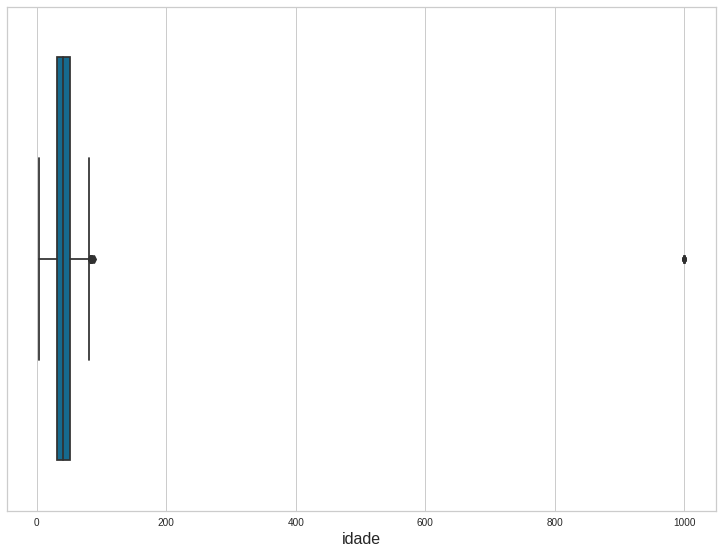

In [ ]:
sns.boxplot(x=df_uniao['idade'])

In [ ]:
df_uniao.loc[(np.abs(stats.zscore(df_uniao['idade'])) >= 3)]

,id,rua_acolhimento,local_da_coleta_de_dados,metodo,turno,data,bairro,ap,codigo_da_rp,rp,codigo_da_ra,ra,latitude,longitude,situacao_entrevista,motivo_situacao_impossivel,dormiu_na_rua_ultimos_7_dias,respondeu_ao_questionario,questionario_de_observacao,idade,faixa_etaria,classificacao_idade,faixa_etaria_observada,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao,zona,ids
63,5815,ACOLHIDOS,UNIDADES DE ACOLHIMENTO,ENTREVISTA,NAO SE APLICA,27/10/2020,PACIENCIA,AP 5,5.3,5.3 - SANTA CRUZ,19,XIX - SANTA CRUZ,"-22,9201883","-43,6489972",POSSIVEL,NAO SE APLICA,NAO SE APLICA,SIM,NAO,999,NAO IDENTIFICADA,SEM INFORMACAO,NAO SE APLICA,FEMININO,MULHER CIS,BRANCA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO SELECIONOU,"TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS",NUNCA TIVE,NO MUNICIPIO DO RIO DE JANEIRO,RIO DE JANEIRO,NAO SE APLICA,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,NAO,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO,NAO SE APLICA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO,NAO,NAO SE APLICA,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,NAO,NAO,

Utilizando a técnica de Z-SCORE para encontrar outliers percebemos que as idades preenchidas com o valor "999" são de indivíduos que se encontravam em cenas de uso de drogas o que realmente tornam os dados imprecisos.

Como o dataset é muito heterogêneo e temos gêneros distintos, cada indivíduo teve a informação preenchida com a media de idade do seu respectivo gênero .

In [ ]:
media_homem = int(np.mean(df_uniao.loc[(df_uniao['genero'] == 'HOMEM CIS') & (df_uniao['idade'] != '999'), 'idade']))
media_mulher = int(np.mean(df_uniao.loc[(df_uniao['genero'] == 'MULHER CIS') & (df_uniao['idade'] != '999'), 'idade']))
df_uniao.loc[(np.abs(stats.zscore(df_uniao['idade'])) >= 3) & (df_uniao['genero'] == 'MULHER CIS'), ['idade']] = media_mulher
df_uniao.loc[(np.abs(stats.zscore(df_uniao['idade'])) >= 3) & (df_uniao['genero'] == 'HOMEM CIS'), ['idade']] = media_homem

In [ ]:
df_uniao = df_uniao.loc[(~df_uniao['genero'].isin(['Não', 'NS/NR', 'Não se aplica']))]
df_uniao = df_uniao.reset_index(drop=True)

Checando novamente percebemos que ainda existem outliers, mas são valores referentes a idade que são perfeitamente possíveis de existir.

In [ ]:
df_uniao.loc[(np.abs(stats.zscore(df_uniao['idade'])) >= 3)]

,id,rua_acolhimento,local_da_coleta_de_dados,metodo,turno,data,bairro,ap,codigo_da_rp,rp,codigo_da_ra,ra,latitude,longitude,situacao_entrevista,motivo_situacao_impossivel,dormiu_na_rua_ultimos_7_dias,respondeu_ao_questionario,questionario_de_observacao,idade,faixa_etaria,classificacao_idade,faixa_etaria_observada,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao,zona,ids
290,5705,ACOLHIDOS,UNIDADES DE ACOLHIMENTO,ENTREVISTA,NAO SE APLICA,27/10/2020,RECREIO DOS BANDEIRANTES,AP 4,4.2,4.2 - BARRA DA TIJUCA,24,XXIV - BARRA DA TIJUCA,"-23,0269786","-43,4860905",POSSIVEL,NAO SE APLICA,NAO SE APLICA,SIM,NAO,89,80 A 89,IDOSO,NAO SE APLICA,FEMININO,MULHER CIS,PARDA,SIM,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,TENHO,TENHO,TENHO,"TIVE, MAS NAO TENHO MAIS",TENHO,NUNCA TIVE,"TIVE, MAS NAO TENHO MAIS",EM OUTRO ESTADO,BAHIA,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,SIM,SIM,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,SIM,OUTROS,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NUNCA PROCUREI ESSES SERVICOS,NAO,NAO SE APLICA,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO,NAO SE APLICA,NAO,NAO,NAO,NAO,SIM,SIM,NAO,NAO,NAO,NAO,NAO,NAO,CLINICA DA FAMILIA/POSTO DE SAUDE,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO SE APLICA,NAO SE 

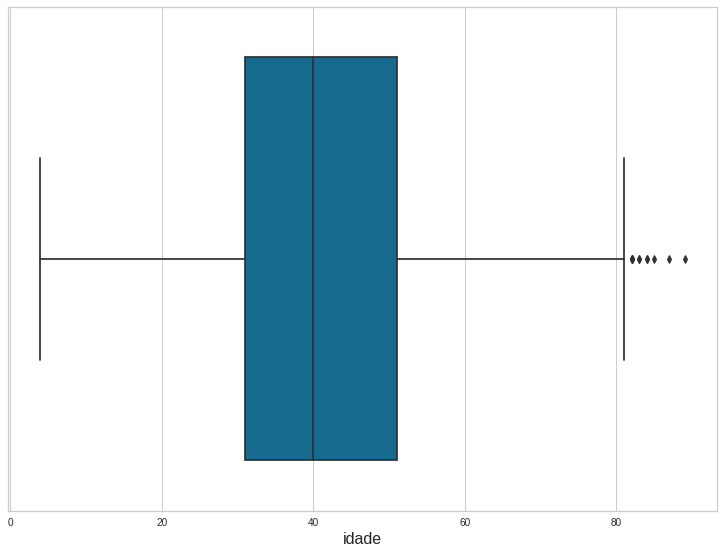

In [ ]:
sns.boxplot(x=df_uniao['idade'])

###2.3.3 - Alteração dos tipos de dados

In [ ]:
df_uniao = df_uniao.apply(lambda x: x.astype('category') if x.dtypes == 'object' or 'codigo' in x.name else x)
df_uniao[['latitude', 'longitude']] = df_uniao[['latitude', 'longitude']].apply(lambda x: x.str.replace(',', '.').astype('float64'))

# 3 - Análise exploratória

Perguntas que eu quero tentar responder durante a análise:
*   Por Gênero, quantos indivíduos estão em situação de rua?
*   Por Raça, quantos indivíduos estão em situação de rua?
*   Escolaridade em relação ao Gênero.
*   Escolaridade em relação a Raça.
*   Motivos para permanecer em situação de rua em relação ao Gênero.
*   Motivos para permanecer em situação de rua em relação a Raça.
*   Em quais faixas etárias se concentram do indivíduos da amostra?
*   Faz uso de Drogas?
*   Habitos de consumo de drogas por região.




In [ ]:
def gera_countplot(alvo, xlabel, ylabel, title):
  ax = sns.countplot(x=df_uniao[alvo])
  ax.set_title(f'{title}\n'); 
  ax.set_xlabel(xlabel); 
  ax.set_ylabel(ylabel); 
  return ax

In [ ]:
def gera_heatmap(alvo, por, xlabel, ylabel, title):
  df = df_uniao.loc[~df_uniao[alvo].isin(['NAO SE APLICA', 'NS/NR']),[alvo, por]]# "~" para negar
  pv = pd.pivot_table(df, index=alvo, columns=por, aggfunc=len, fill_value=0)
  ax = sns.heatmap(pv, cmap="BuPu", annot=True, fmt ='d', linewidths=.5, xticklabels=True, yticklabels=True)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(f'{title}\n')
  return ax

## 3.1 - Por Gênero, quantos indivíduos estão em situação de rua?

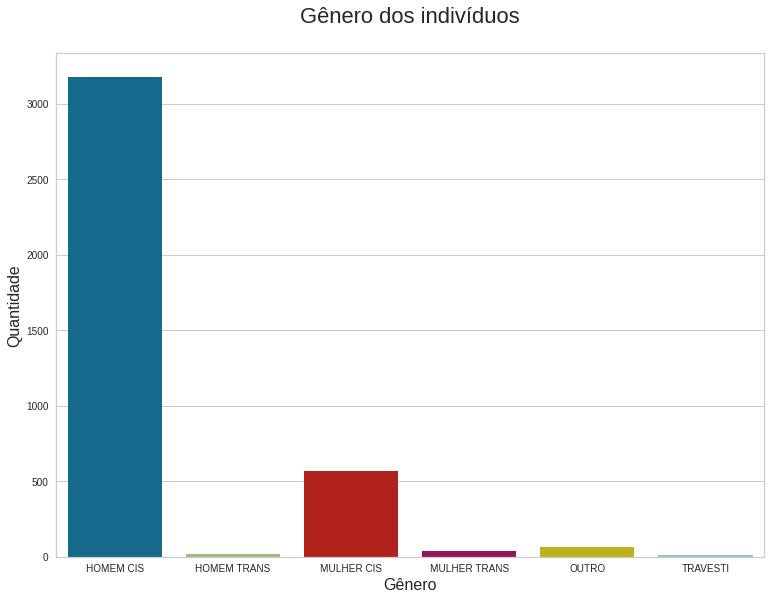

In [ ]:
rua_genero = gera_countplot('genero', 'Gênero', 'Quantidade', 'Gênero dos indivíduos')
plt.show()

## 3.2 - Por Raça, quantos indivíduos estão em situação de rua?

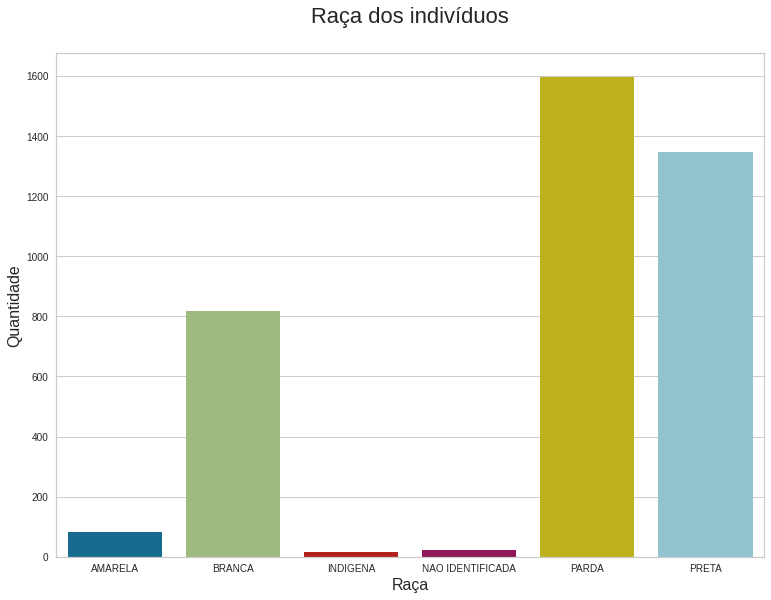

In [ ]:
rua_raca = gera_countplot('cor_raca', 'Raça', 'Quantidade', 'Raça dos indivíduos')
plt.show()

## 3.3 - Escolaridade em relação a Gênero.

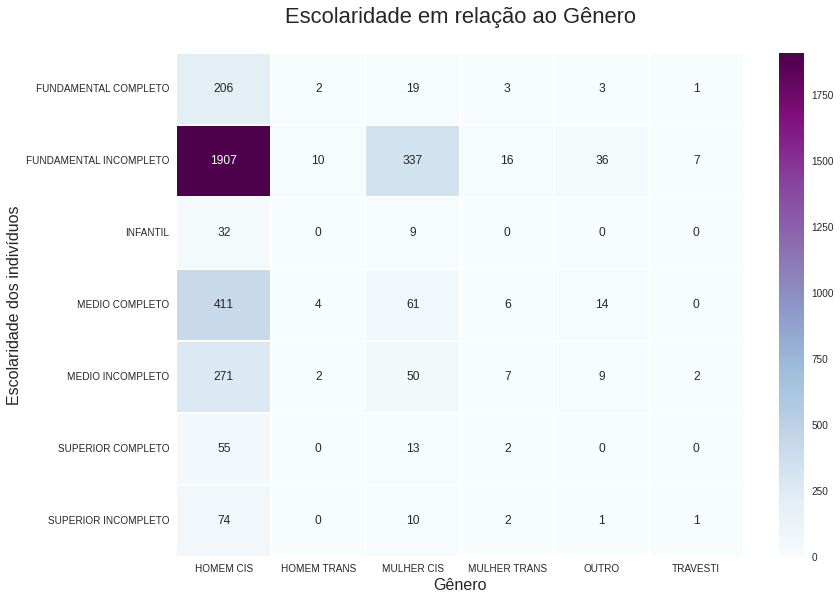

In [ ]:
hm_escolaridade = gera_heatmap('escolaridade', 'genero', 'Gênero', 'Escolaridade dos indivíduos', 'Escolaridade em relação ao Gênero')
plt.show()

## 3.4 - Escolaridade em relação a Raça.

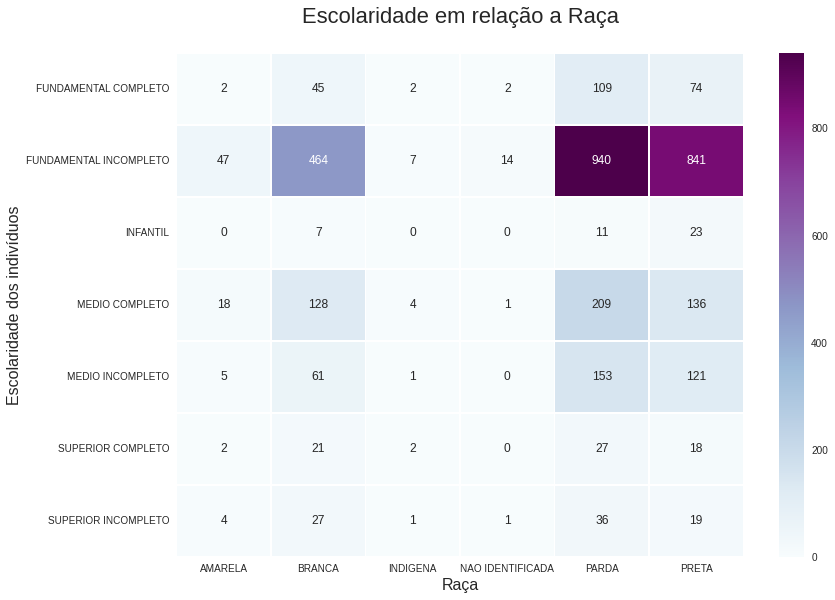

In [ ]:
hm_escolaridade = gera_heatmap('escolaridade', 'cor_raca', 'Raça', 'Escolaridade dos indivíduos', 'Escolaridade em relação a Raça')
plt.show()

## 3.5 - Motivos para permanecer em situação de rua em relação ao Gênero.

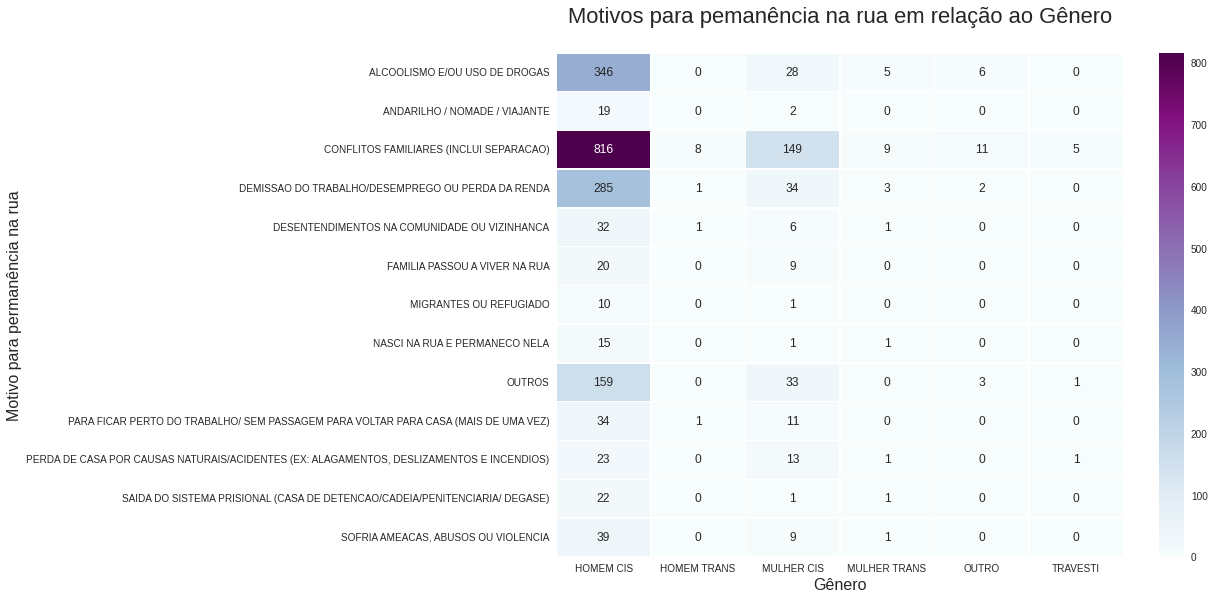

In [ ]:
hm_motivos_rua = gera_heatmap('motivo_dormir_rua', 'genero', 'Gênero', 'Motivo para permanência na rua', 'Motivos para pemanência na rua em relação ao Gênero')
plt.show()

## 3.6 - Motivos para permanecer em situação de rua em relação a Raça.

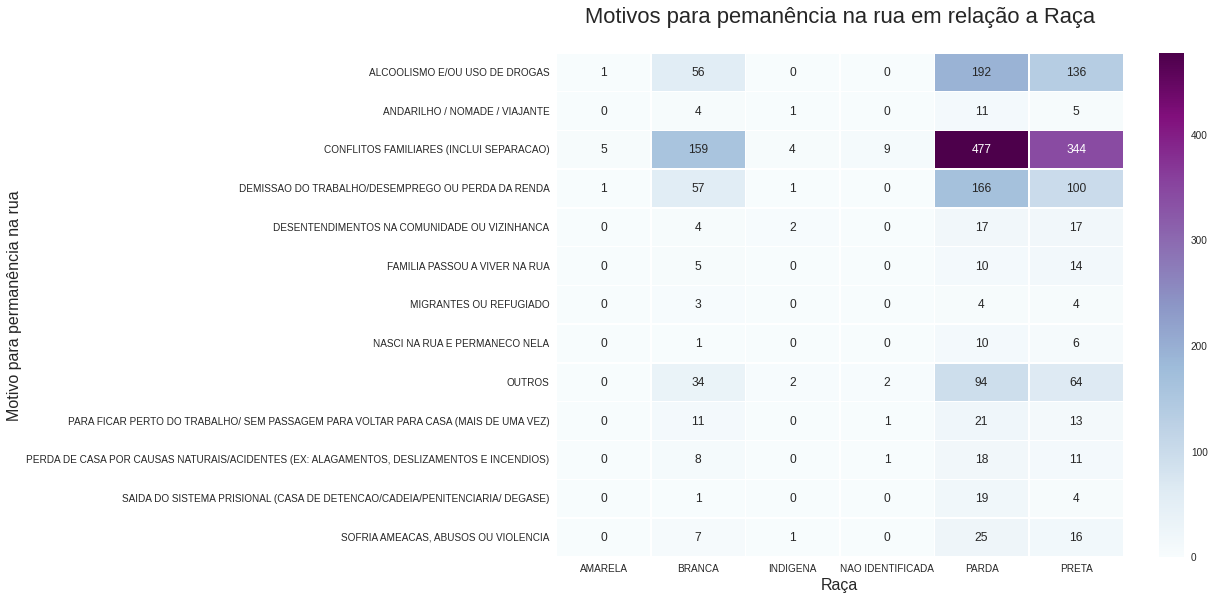

In [ ]:
hm_motivos_rua = gera_heatmap('motivo_dormir_rua', 'cor_raca', 'Raça', 'Motivo para permanência na rua', 'Motivos para pemanência na rua em relação a Raça')
plt.show()

## 3.7 - Em quais faixas etárias se concentram do indivíduos da amostra?

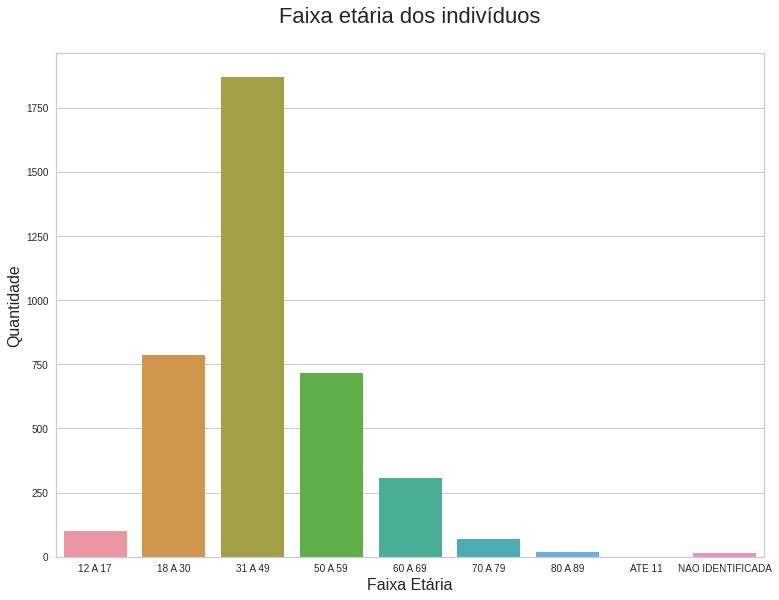

In [ ]:
cp_faixa = gera_countplot('faixa_etaria', 'Faixa Etária', 'Quantidade', 'Faixa etária dos indivíduos')
plt.show()

##3.8 - Faz uso de Drogas?

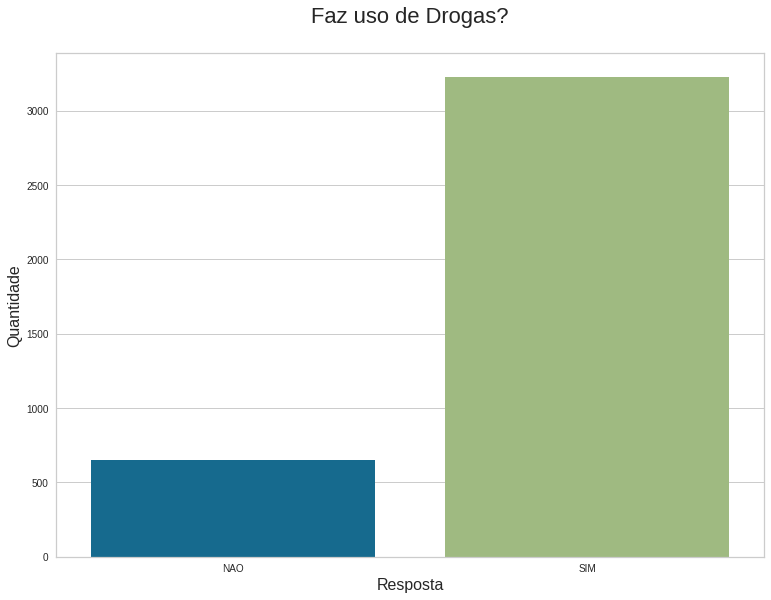

In [ ]:
cp_drogas = gera_countplot('faz_uso_drogas', 'Resposta', 'Quantidade', 'Faz uso de Drogas?')
plt.show()

## 3.9 - Hábitos de Dependência Química por região.

In [ ]:
drogas = ['drogas_tabaco',
 'drogas_alcool',
 'drogas_maconha_haxixe',
 'drogas_crack_similares',
 'drogas_cocaina',
 'drogas_inalan_cola_solven_tiner']
df_drogas_x_zona = pd.DataFrame()
for d in drogas:  
  df_drogas_x_zona[d] = df_uniao.loc[df_uniao[d] == 'SIM'].groupby('zona').size().reset_index(name='counts')['counts']
df_drogas_x_zona.index = ['CENTRAL', 'NORTE', 'OESTE', 'SUL']

Text(0.5, 1.0, 'Hábitos de Depêndencia Química por zona\n')

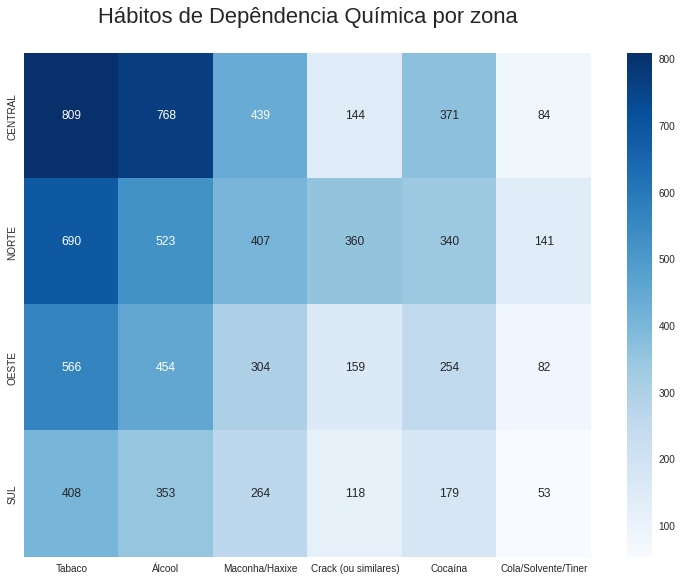

In [ ]:
sns.heatmap(df_drogas_x_zona, annot=True, cmap="Blues", fmt="d", xticklabels=["Tabaco", "Álcool", "Maconha/Haxixe", "Crack (ou similares)", "Cocaína", "Cola/Solvente/Tiner"]).set_title('Hábitos de Depêndencia Química por zona\n')

##Agrupando hábitos de Dependência Química por região

In [ ]:
df_uniao.groupby(['zona']).mean().sort_values('ids', ascending=False)['ids']

zona
SUL        0.734510
NORTE      0.608652
CENTRAL    0.607564
OESTE      0.545256
Name: ids, dtype: float64

# 4 - Modelagem de Machine Learning

Nessa seção iremos aplicar alguns algoritmos de Machine Learning para analisar a classificação do nosso modelo. Para a criação dos modelos de Machine Learning iremos testar 3 algoritmos de classificação: Naive Bayes, Árvore de Decisão e Random Forest.

Limpeza de dados redundantes

As features descritas abaixo são redundantes ou apresentam sempre o mesmo valor, ou trazem caracteristicas sobre a pesquisa e não sobre o indivíduo por isso optei por removê-las, no documento que acompanha este notebook detalho os motivos. 

In [ ]:
df_uniao_ml = df_uniao.drop(columns=['id','rua_acolhimento', 'metodo', 'turno', 'data','rp', 'ra', 'situacao_entrevista', 'motivo_situacao_impossivel','respondeu_ao_questionario', 'questionario_de_observacao','faixa_etaria_observada', 'faixa_etaria'])   

In [ ]:
X = df_uniao_ml.drop(columns=['faz_uso_drogas'])
y = df_uniao_ml['faz_uso_drogas']

In [ ]:
X = X.apply(lambda x: x.cat.codes if x.dtypes == 'category' else x)

Dividindo base de Teste e de Treino.

Consideramos 70% da base para treino e 30% para teste.

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.70, test_size=0.30, stratify=y)

In [ ]:
train_X.shape

(2717, 117)

In [ ]:
train_y.shape

(2717,)

In [ ]:
test_X.shape, test_y.shape

((1165, 117), (1165,))

In [ ]:
df_uniao_ml

,local_da_coleta_de_dados,bairro,ap,codigo_da_rp,codigo_da_ra,latitude,longitude,dormiu_na_rua_ultimos_7_dias,idade,classificacao_idade,sexo,genero,cor_raca,deficiencia_caminhar_ou_degraus,deficiencia_enxergar,deficiencia_ouvir,deficiencia_mental,deficiencia_nao_possui,deficiencia_ns_nr,documento_certidao_de_nascimento,documento_cpf,documento_carteira_de_identidade,documento_carteira_de_trabalho,documento_titulo_de_eleitor,documento_passaporte,documento_red,naturalidade,estado,municipio,voltar_cidade_natal,contato_familia,contato_familia_complemento,familia_dorme_rua_acolhimento,ha_criancas,residencia_fixa,residencia_fixa_complemento,dias_dormiu_rua_ultimos_30dias,motivo_dormir_rua,tempo_rua_rj,rua_inicio_coronavirus,motivo_rua_depois_coronavirus,ajuda_pandemia,ajuda_auxilio_emergencial,ajuda_alimentos,ajuda_itens_higiene,ajuda_mascaras_protecao,ajuda_oferta_lugares_higiene,ajuda_ns_nr,local_anterior_dormitorio,local_dormitorio,dormiu_rua_maioria_ultimos_7dias,lugar_7_dias,bairro_7_dias,dormiu_abrigo_prefeitura,dormiu_abrigo_quanto_tempo,dificuldade_abrigo,abrigos_apresentam_problemas,principal_problema_abrigo,foi_atendido_cras,foi_atendido_creas,foi_atendido_centro_pop,foi_atendido_abordagem_social,foi_atendido_conselho_tutelar,foi_atendido_acolhimento,foi_atendido_central_de_recepcao,foi_atendido_hotel,foi_atendido_defensoria_publica,foi_atendido_nao_foi_atendido,foi_atendido_ns/nr,dificuldades_atendimento_servico,atividade_remunerada,atividade_realizada,recebe_outras_fontes_de_renda,outras_fontes_bolsa_familia,outras_fontes_aux_emergencial,outras_fontes_bpc,outras_fontes_aposentado_pensao,outras_fontes_auxilio_doenca,outras_fontes_aht_aluguel_social,outras_fontes_outros,outras_fontes_nao_recebe,outras_fontes_ns/nr,gravidez,acompanhamento_pre_natal,problema_saude_diabetes,problema_saude_pressao_alta,problema_saude_hiv_aids,problema_saude_sifilis_ou_ists,problema_saude_asma_bronq_pneum,problema_saude_tuberculose,problema_saude_cancer_tumores,problema_saude_hepatite,problema_saude_mental_epilepsia,problema_saude_lepra_outras,problema_saude_infeccao_urinaria,problema_saude_ferim_frat_outros,qual_unidade_saude_procura,faz_uso_drogas,drogas_tabaco,drogas_alcool,drogas_maconha_haxixe,drogas_crack_similares,drogas_cocaina,drogas_inalan_cola_solven_tiner,frequencia_tabaco,frequencia_alcool,frequencia_maconha/haxixe,frequencia_crack/similares,frequencia_cocaina,frequencia_inal_cola_solv_tiner,motivo_droga,motivo_local_uso_droga,sabe_ler_escrever,frequentou_escola,escolaridade,necessidade_sair_situacao,zona,ids
0,RUA,PACIENCIA,AP 5,5.3,19,-22.917108,-43.634687,SIM,22,ADULTO,MASCULINO,HOMEM CIS,PRETA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,"TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS","TIVE, MAS NAO TENHO MAIS",NUNCA TIVE,NUNCA TIVE,NO MUNICIPIO DO RIO DE JANEIRO,RIO DE JANEIRO,NAO SE APLICA,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,NAO,NS/NR,NS/NR,NS/NR,NAO,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NS/NR,NAO SE APLICA,RUA,EM UM BAIRRO DA CIDADE DO RIO DE JANEIRO,PACIENCIA,NAO,NAO SE APLICA,NAO,NAO,NAO SE APLICA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO,NAO,NAO SE APLICA,SIM,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELECIONOU,NAO SE APLICA,NAO SE APLICA,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO,HOSPITAL OU CER,NAO,NAO,NAO,NAO,NAO,NAO,NAO,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,NAO SE APLICA,SIM,"SIM, JA ESTUDEI",FUNDAMENTAL INCOMPLETO,NAO QUERO SAIR DA RUA,OESTE,0.482
1,RUA,PACIENCIA,AP 5,5.3,19,-22.926222,-43.642445,SIM,50,ADULTO,MASCULINO,HOMEM CIS,PRETA,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,NAO SELECIONOU,SIM,NAO SELEC

##4.1 - Naive Bayes

In [ ]:
naive_df_uniao_ml = GaussianNB()
naive_df_uniao_ml.fit(train_X, train_y)


GaussianNB()

In [ ]:
previsoes_NB = naive_df_uniao_ml.predict_proba(test_X)
previsoes = naive_df_uniao_ml.predict(test_X)

In [ ]:
previsoes

array(['SIM', 'SIM', 'SIM', ..., 'SIM', 'SIM', 'SIM'], dtype='<U3')

In [ ]:
previsoes_NB

array([[8.11237495e-220, 1.00000000e+000],
       [9.63515890e-134, 1.00000000e+000],
       [4.66524996e-055, 1.00000000e+000],
       ...,
       [0.00000000e+000, 1.00000000e+000],
       [1.16963030e-086, 1.00000000e+000],
       [1.65477437e-046, 1.00000000e+000]])

In [ ]:
accuracy_score(test_y, previsoes)

0.9948497854077253

In [ ]:
confusion_matrix(test_y, previsoes)

array([[191,   5],
       [  1, 968]])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


0.9948497854077253

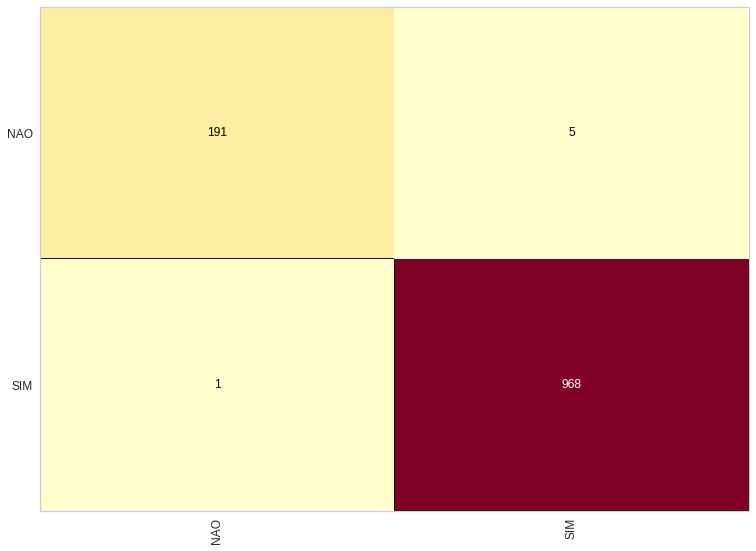

In [ ]:
cm = ConfusionMatrix(naive_df_uniao_ml)
cm.fit(train_X, train_y)
cm.score(test_X, test_y)

In [ ]:
print(classification_report(test_y, previsoes))

              precision    recall  f1-score   support

         NAO       0.99      0.97      0.98       196
         SIM       0.99      1.00      1.00       969

    accuracy                           0.99      1165
   macro avg       0.99      0.99      0.99      1165
weighted avg       0.99      0.99      0.99      1165



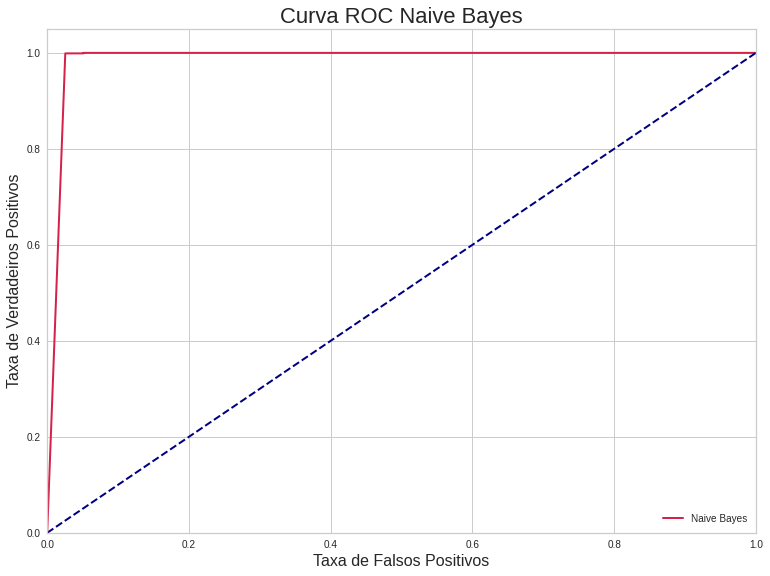

In [ ]:
labelencoder = LabelEncoder()
encoded_y = labelencoder.fit_transform(test_y)
fpr, tpr, thresholds = roc_curve(encoded_y, previsoes_NB[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label= 'Naive Bayes', color= '#d5224a')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Naive Bayes')
plt.legend(loc="lower right")
plt.show()



##4.2 - Árvore de Decisão

In [ ]:
arvore_df_uniao_ml = DecisionTreeClassifier(criterion='entropy', random_state=0)
arvore_df_uniao_ml.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
previsoes = arvore_df_uniao_ml.predict(test_X)
previsoes_DT = naive_df_uniao_ml.predict_proba(test_X)[:, 1]


In [ ]:
previsoes

array(['SIM', 'SIM', 'SIM', ..., 'SIM', 'NAO', 'SIM'], dtype=object)

In [ ]:
previsoes_DT

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
accuracy_score(test_y, previsoes)

1.0

In [ ]:
confusion_matrix(test_y, previsoes)

array([[196,   0],
       [  0, 969]])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


1.0

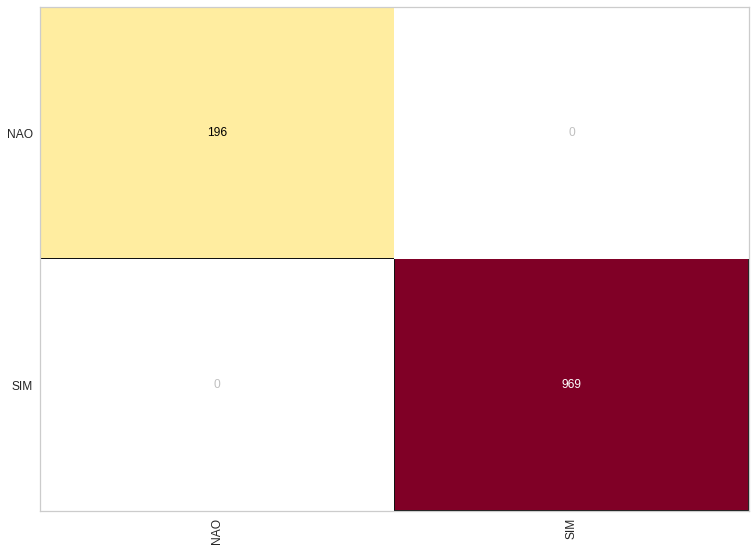

In [ ]:

cm = ConfusionMatrix(arvore_df_uniao_ml)
cm.fit(train_X, train_y)
cm.score(test_X, test_y)

In [ ]:
print(classification_report(test_y, previsoes))

              precision    recall  f1-score   support

         NAO       1.00      1.00      1.00       196
         SIM       1.00      1.00      1.00       969

    accuracy                           1.00      1165
   macro avg       1.00      1.00      1.00      1165
weighted avg       1.00      1.00      1.00      1165



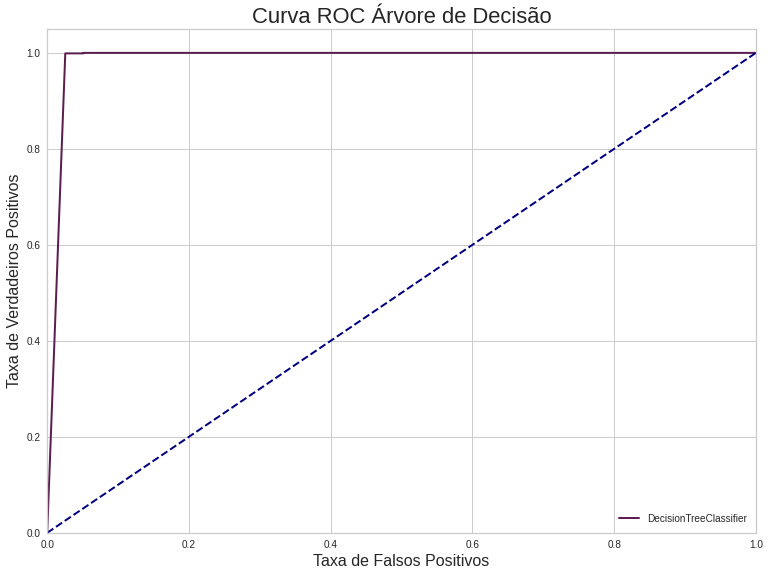

In [ ]:
fpr, tpr, thresholds = roc_curve(encoded_y, previsoes_DT)
roc_auc = roc_auc_score(encoded_y, previsoes_DT)


plt.plot(fpr, tpr, lw=2, label= 'DecisionTreeClassifier', color= '#5c1e51')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Árvore de Decisão')
plt.legend(loc="lower right")
plt.show()

##4.3 - Randon Forest

In [ ]:
random_forest_df_uniao_ml = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 0)
random_forest_df_uniao_ml.fit(train_X, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=40, random_state=0)

In [ ]:
previsoes = random_forest_df_uniao_ml.predict(test_X)
previsoes_RF = random_forest_df_uniao_ml.predict_proba(test_X)[:, 1]


In [ ]:
previsoes

array(['SIM', 'SIM', 'SIM', ..., 'SIM', 'SIM', 'SIM'], dtype=object)

In [ ]:
previsoes_RF

array([1.   , 1.   , 0.825, ..., 1.   , 0.575, 0.925])

In [ ]:

accuracy_score(test_y, previsoes)

0.9948497854077253

In [ ]:
confusion_matrix(test_y, previsoes)

array([[190,   6],
       [  0, 969]])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9948497854077253

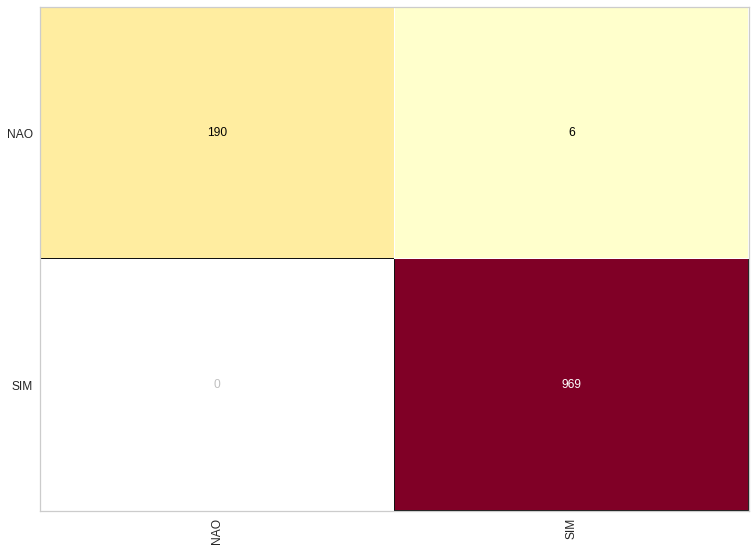

In [ ]:

cm = ConfusionMatrix(random_forest_df_uniao_ml)
cm.fit(train_X, train_y)
cm.score(test_X, test_y)

In [ ]:
print(classification_report(test_y, previsoes))

              precision    recall  f1-score   support

         NAO       1.00      0.97      0.98       196
         SIM       0.99      1.00      1.00       969

    accuracy                           0.99      1165
   macro avg       1.00      0.98      0.99      1165
weighted avg       0.99      0.99      0.99      1165



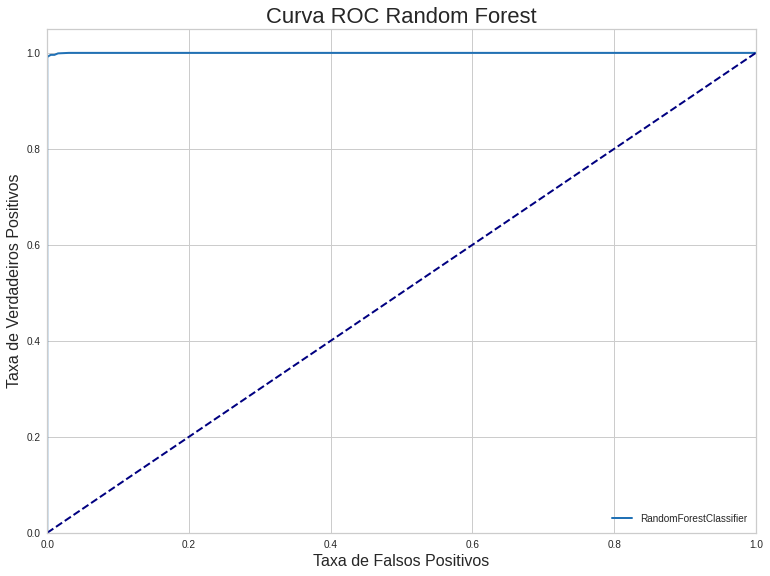

In [ ]:
fpr, tpr, thresholds = roc_curve(encoded_y, previsoes_RF)
roc_auc = roc_auc_score(encoded_y, previsoes_RF)

plt.plot(fpr, tpr, lw=2, label= 'RandomForestClassifier', color= '#2171b5')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Random Forest')
plt.legend(loc="lower right")
plt.show()